# tutorial 03

## ABS with mask

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

- import fits maps

In [2]:
map95 = hp.read_map('./data/TQU_95GHz_r6.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map150 = hp.read_map('./data/TQU_150GHz_r6.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map353 = hp.read_map('./data/TQU_353GHz_r6.fits',field=[0,1,2],dtype=np.float64,verbose=0)
mapcmb = hp.read_map('./data/TQU_CMB_r6.fits',field=[0,1,2],dtype=np.float64,verbose=0)
print (map95.shape, map95.dtype)

(3, 49152) float64


- mask preparation

In [3]:
# iso-angular-separation mask generator
def mask_map_prod(nside, clon, clat, sep):
    _c = np.pi/180
    def hav(theta):
        return 0.5-0.5*np.cos(theta)
    _tmp = np.ones(hp.nside2npix(nside),dtype=bool)
    _count = 0
    for _ipix in range(len(_tmp)):
        _lon,_lat = hp.pix2ang(nside,_ipix,lonlat=True)
        # iso-angle separation
        if((hav(np.fabs(clat-_lat)*_c)+np.cos(clat*_c)*np.cos(_lat*_c)*hav(np.fabs(clon-_lon)*_c))>hav(sep*_c)):
            _count = _count + 1
            _tmp[_ipix] = False
    print ('sky faction: ', (1 - _count/(12*nside*nside)))
    return _tmp

- Ali mask

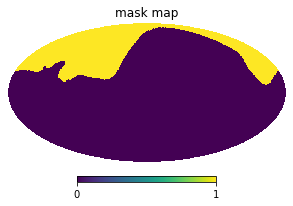

In [6]:
mask = hp.read_map('./data/Ali_mask_r6.fits',verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='mask map',hold=True)

sky faction:  0.03076171875


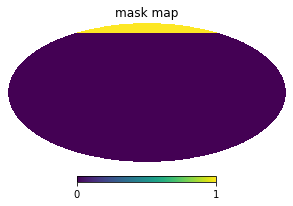

In [17]:
mask = mask_map_prod(64, 0, 90, 20)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='mask map',hold=True)

- PS estimation requires a built-in PS estimator (by default NaMaster)

In [18]:
est = ap.pstimator()
BIN = 10
APOD = 1.

f95auto = est.auto_teb(list(map95),mask,
                       aposcale=APOD,binning=BIN)
f150auto = est.auto_teb(list(map150),mask,
                        aposcale=APOD,binning=BIN)
f353auto = est.auto_teb(list(map353),mask,
                        aposcale=APOD,binning=BIN)

f95f150 = est.cross_teb(list(np.vstack([map95,map150])),
                        mask,aposcale=APOD,binning=BIN)
f95f353 = est.cross_teb(list(np.vstack([map95,map353])),
                        mask,aposcale=APOD,binning=BIN)
f150f353 = est.cross_teb(list(np.vstack([map150,map353])),
                         mask,aposcale=APOD,binning=BIN)

In [23]:
Nfreq = 3  # 95,150,353
Llist = list(f95auto[0])
Nell = len(Llist)

print ('ell list',Llist)

tt_total = np.zeros((Nell,Nfreq,Nfreq))
ee_total = np.zeros((Nell,Nfreq,Nfreq))
bb_total = np.zeros((Nell,Nfreq,Nfreq))

for i in range(Nell):
    # diagnoal
    tt_total[i,0,0] = f95auto[1][i]
    tt_total[i,1,1] = f150auto[1][i]
    tt_total[i,2,2] = f353auto[1][i]
    
    ee_total[i,0,0] = f95auto[2][i]
    ee_total[i,1,1] = f150auto[2][i]
    ee_total[i,2,2] = f353auto[2][i]
    
    bb_total[i,0,0] = f95auto[3][i]
    bb_total[i,1,1] = f150auto[3][i]
    bb_total[i,2,2] = f353auto[3][i]
    # cross
    tt_total[i,0,1] = f95f150[1][i]
    tt_total[i,0,2] = f95f353[1][i]
    tt_total[i,1,2] = f150f353[1][i]
    tt_total[i,1,0] = tt_total[i,0,1]
    tt_total[i,2,0] = tt_total[i,0,2]
    tt_total[i,2,1] = tt_total[i,1,2]
    
    ee_total[i,0,1] = f95f150[2][i]
    ee_total[i,0,2] = f95f353[2][i]
    ee_total[i,1,2] = f150f353[2][i]
    ee_total[i,1,0] = ee_total[i,0,1]
    ee_total[i,2,0] = ee_total[i,0,2]
    ee_total[i,2,1] = ee_total[i,1,2]
    
    bb_total[i,0,1] = f95f150[3][i]
    bb_total[i,0,2] = f95f353[3][i]
    bb_total[i,1,2] = f150f353[3][i]
    bb_total[i,1,0] = bb_total[i,0,1]
    bb_total[i,2,0] = bb_total[i,0,2]
    bb_total[i,2,1] = bb_total[i,1,2]

ell list [6.5, 16.5, 26.5, 36.5, 46.5, 56.5, 66.5, 76.5, 86.5, 96.5, 106.5, 116.5, 126.5, 136.5, 146.5, 156.5, 166.5, 176.5, 186.5]


In [20]:
separator = ap.abssep(tt_total,llist=Llist,lbin=5,shift=10.,cut=1.)
rslt_tt = separator()
separator = ap.abssep(ee_total,llist=Llist,lbin=5,shift=10.,cut=1.)
rslt_ee = separator()
separator = ap.abssep(bb_total,llist=Llist,lbin=5,shift=10.,cut=1.)
rslt_bb = separator()

(1e-07, 10000000.0)

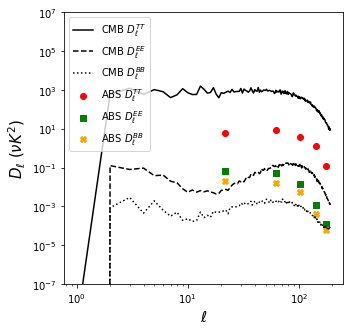

In [21]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_tt[0],rslt_tt[1],
           color='red',marker='o',label=r'ABS $D^{TT}_\ell$')
ax.scatter(rslt_ee[0],rslt_ee[1],
           color='green',marker='s',label=r'ABS $D^{EE}_\ell$')
ax.scatter(rslt_bb[0],rslt_bb[1],
           color='orange',marker='X',label=r'ABS $D^{BB}_\ell$')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(cmb_cl.shape[1])
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[0],
        color='black',linestyle='-',label=r'CMB $D^{TT}_\ell$')
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[1],
        color='black',linestyle='--',label=r'CMB $D^{EE}_\ell$')
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[2],
        color='black',linestyle=':',label=r'CMB $D^{BB}_\ell$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\nu K^2$)',fontsize=15)
ax.set_ylim((1.e-7,1.e7))

end